In [1]:
import matplotlib.pyplot as plt
import time
from IPython.display import display
from xml.dom import minidom
import math
import folium
import pandas as pd
from pandas.io.json import json_normalize
import tqdm 
import numpy as np
import geopandas as gpd
import contextily as cx
from random import randint
import json

import warnings
warnings.filterwarnings("ignore")

# Routes

In [35]:
# from pyproj import Transformer
# stops= pd.read_excel('./Data/GIS/bus_routes/stops.xlsx')
# transformer = Transformer.from_crs("EPSG:32636", "EPSG:4326")
# transformed_coords= transformer.transform(stops.x, stops.y)
# stops['x']= transformed_coords[0]
# stops['x']= transformed_coords[1]
# stops.head()

,OBJECTID,stop_name,x,y,neighborhood
0,1,سوق الموردة,32.489899,1727851,الهجرة
1,2,بوابة عبد القيوم,32.491548,1728361,الهجرة
2,3,بوابة عبد القيوم,32.491371,1728342,الهجرة
3,4,داخلية علي عبد الفتاح,32.490889,1728618,الهجرة
4,5,الدآيات,32.490532,1728725,الهجرة


In [21]:
routes= gpd.read_file('./transit_map/shp/Transport Routes with Num ID.shp')
#routes.drop_duplicates(subset= 'geometry', inplace= True)

In [22]:
routes= routes.to_crs(epsg=4326)

In [23]:
# Create a unique identifier for each LineString
routes['geometry_str'] = routes['geometry'].astype(str)

# Identify objects with identical routes
duplicates = routes.groupby('geometry_str').filter(lambda x: len(x) > 1)
duplicates.sort_values(by= ['Name', 'Routes_n_4'], inplace= True)

In [24]:
for index in duplicates[duplicates.Routes_n_4 == 'back'].index.values:
    try:
        routes.at[index, 'geometry'].coords = duplicates.at[index-1, 'geometry'].coords[::-1]
    except:
        print(f'Failed at {index}')
        continue
        
routes.drop_duplicates(subset= 'geometry', inplace= True)

Failed at 219
Failed at 207
Failed at 232
Failed at 85
Failed at 243
Failed at 366
Failed at 233
Failed at 362
Failed at 223
Failed at 404
Failed at 235
Failed at 165


In [25]:
routes.rename(columns= {'OBJECTID':'shape_id'}, inplace= True)
routes.shape_id = routes.shape_id.astype('int')
routes.shape_id = routes.shape_id.astype('str')
routes.shape_id = routes.shape_id.astype(str).apply(lambda x: "shp_"+x)

In [26]:
routes.head()

,shape_id,Name,Station_ID,Bus_type,Fees,Trip_Type,SHAPE_Leng,Routes_nam,Routes_n_1,Routes_n_2,Routes_n_3,Routes_n_4,Routes_n_5,Routes_n_6,Routes_n_7,geometry,geometry_str
0,shp_1,الخرطوم - السوق المحلي,None,None,None,1.0,9462.706579,الخرطوم - السوق المحلي,None,None,None,back,9462.706579,71.0,71.0,"LINESTRING (32.54371 15.52087, 32.54364 15.521...",LINESTRING (32.54371393354722 15.5208729790680...
1,shp_2,الخرطوم - السوق المركزي,None,None,None,1.0,9123.981371,الخرطوم - السوق المركزي,None,None,None,back,9123.981371,72.0,72.0,"LINESTRING (32.54965 15.53139, 32.54870 15.537...",LINESTRING (32.54965471346372 15.5313902840863...
2,shp_3,الخرطوم - اركويت,None,None,None,1.0,10560.812416,الخرطوم - اركويت,None,None,None,back,10560.812416,75.0,75.0,"LINESTRING (32.56347 15.53835, 32.56306 15.540...",LINESTRING (32.56347361045869 15.5383531683958...
3,shp_4,الخرطوم - السوق المحلي,None,None,None,0.0,8983.359243,الخرطوم - السوق المحلي,None,None,None,start,8983.359243,NaN,71.0,"LINESTRING (32.52158 15.59317, 32.52162 15.592...",LINESTRING (32.521577993923295 15.593169579270...
4,shp_5,الخرطوم - السوق المركزي,None,None,None,0.0,8950.474195,الخرطوم - السوق المركزي,None,None,None,start,8950.474195,NaN,72.0,"LINESTRING (32.52158 15.59317, 32.52162 15.592...",LINESTRING (32.521577993923295 15.593169579270...


In [28]:
routes= routes[['shape_id', 'geometry']] #routes= routes[['shape_id', 'Name', 'Trip_Type', 'geometry']]

In [29]:
routes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
routes= routes.to_crs(epsg=4326)

In [53]:
idx_to_drop= [
    50, 51, 84, 85, 96, 97, 190, 191, 206, 207, 216, 217, 218, 219, 222, 223,
    230, 231, 232, 233, 234, 235, 236, 237, 242, 243, 358, 361, 362, 365, 366
]

In [55]:
#routes.drop(idx_to_drop).to_file("shapes.geojson", driver="GeoJSON")

In [ ]:
routes.to_excel('krt_routes_onemap.xlsx', index= False)

In [ ]:
routes.to_file('krt_routes_onemap.json', driver='GeoJSON')

<AxesSubplot:>

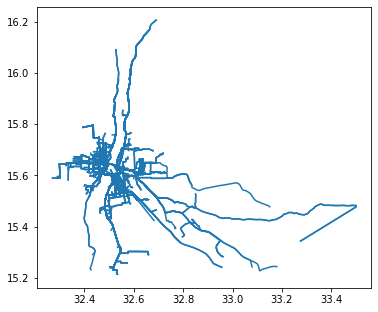

In [32]:
routes.plot(figsize=(6, 6))

In [10]:
import pandas as pd
from pandas.io.json import json_normalize
import json
import requests
from shapely.geometry import LineString

def map_match(route):
    meili = pd.DataFrame(route.geometry.coords[:], columns= ['lon', 'lat'])
    
    insert_rows = 50   # generate intermediate points
    meili.index = range(0, insert_rows * len(meili), insert_rows)
    meili = meili.reindex(index = range(insert_rows * len(meili))) 
    meili= meili.interpolate(method='linear', limit=insert_rows)

    #Preparing the request to Valhalla's Meili
    meili_coordinates = meili.to_json(orient='records')
    meili_head = '{"shape":'
    meili_tail = ""","search_radius": 150, "shape_match":"map_snap", "costing":"auto", "format":"osrm"}""" 
    meili_request_body = meili_head + meili_coordinates + meili_tail

    #Sending a request to Valhalla's Meili
    #url = "http://localhost:8002/trace_route" ### local host needs to be set up
    url = "https://valhalla1.openstreetmap.de/trace_route" ### use Valhalla public server in the interim
    headers = {'Content-type': 'application/json'}
    data = str(meili_request_body)
    try:
        r = requests.post(url, data=data, headers=headers)
    except:
        print('Valhalla server at limit. Map Matching failed!')

    #Receiving Valhalla's Meili response
    if r.status_code == 200:    
        response_text = json.loads(r.text)
        response = str(response_text['tracepoints'])
        response = response.replace("'waypoint_index': None", "'waypoint_index': '#'")
        response = response.replace("None", "{'matchings_index': '#', 'name': '', 'waypoint_index': '#', 'alternatives_count': 0, 'distance': 0, 'location': [0.0, 0.0]}")
        response = response.replace("'", '"')
        response = json.dumps(response)
        response = json.loads(response)

        #Create a dataframe for response contents
        response_df = pd.read_json(response)
        response_df = response_df[['name', 'distance', 'location']]
        map_matched_df = pd.merge(meili, response_df, left_index=True, right_index=True)

        #Break down location into longitude and latitude for matched coordinates
        for i, row in map_matched_df.iterrows():
            map_matched_df.at[i, 'longitude'] = map_matched_df.at[i,'location'][0]
            map_matched_df.at[i, 'latitude'] = map_matched_df.at[i,'location'][1]

            #Formatting: saving Meili output + original cooridinates for unmatched points
            if map_matched_df.at[i, 'longitude'] == 0.0:
                map_matched_df.at[i, 'longitude'] = map_matched_df.at[i,'lon']
                map_matched_df.at[i, 'latitude'] = map_matched_df.at[i,'lat']

        map_matched_df = map_matched_df.drop(['location', 'lon', 'lat'], 1)
        map_matched_df.rename(columns={'longitude': 'lon', 'latitude':'lat'}, inplace= True)
        map_matched_df['distance']= map_matched_df.distance.cumsum() #*0.3048

    return map_matched_df

In [11]:
routes.reset_index(drop= True, inplace= True)

with tqdm.tqdm(total= len(routes), position=0, leave=True) as pbar:
    for i in range(len(routes)):
        pbar.update(1)
        try:
            mm= map_match(routes.iloc[i])
            routes.iat[i, 1]= LineString(zip(mm['lon'], mm['lat']))
            time.sleep(1)
        except:
            print(f'Map-matching unsuccessful for {routes.iat[i,0]}.')
            continue

 10%|████                                      | 51/535 [01:43<17:42,  2.20s/it]

Map-matching unsuccessful for shp_51.
Map-matching unsuccessful for shp_52.


 16%|██████▌                                   | 84/535 [03:31<53:27,  7.11s/it]

Map-matching unsuccessful for shp_85.


 17%|███████                                   | 90/535 [03:53<29:16,  3.95s/it]

Map-matching unsuccessful for shp_91.


 18%|███████▍                                  | 94/535 [04:04<20:49,  2.83s/it]

Map-matching unsuccessful for shp_97.
Map-matching unsuccessful for shp_98.


 20%|████████▏                                | 107/535 [04:34<22:02,  3.09s/it]

Map-matching unsuccessful for shp_110.


 20%|████████▎                                | 109/535 [04:40<20:26,  2.88s/it]

Map-matching unsuccessful for shp_112.


 21%|████████▌                                | 111/535 [04:45<18:42,  2.65s/it]

Map-matching unsuccessful for shp_114.


 21%|████████▋                                | 113/535 [04:50<17:59,  2.56s/it]

Map-matching unsuccessful for shp_116.


 29%|███████████▉                             | 156/535 [06:59<09:15,  1.47s/it]

Map-matching unsuccessful for shp_163.


 32%|█████████████▏                           | 172/535 [07:28<07:47,  1.29s/it]

Map-matching unsuccessful for shp_183.


 33%|█████████████▋                           | 178/535 [07:41<13:49,  2.32s/it]

Map-matching unsuccessful for shp_191.


 36%|██████████████▋                          | 192/535 [08:34<22:09,  3.88s/it]

Map-matching unsuccessful for shp_207.


 38%|███████████████▍                         | 201/535 [09:02<17:06,  3.07s/it]

Map-matching unsuccessful for shp_217.
Map-matching unsuccessful for shp_218.
Map-matching unsuccessful for shp_219.


 39%|███████████████▊                         | 206/535 [09:19<21:13,  3.87s/it]

Map-matching unsuccessful for shp_223.


 40%|████████████████▎                        | 213/535 [09:38<13:48,  2.57s/it]

Map-matching unsuccessful for shp_231.
Map-matching unsuccessful for shp_232.
Map-matching unsuccessful for shp_235.
Map-matching unsuccessful for shp_237.


 61%|█████████████████████████▏               | 329/535 [15:41<10:10,  2.96s/it]

Map-matching unsuccessful for shp_359.


 62%|█████████████████████████▍               | 332/535 [15:46<07:46,  2.30s/it]

Map-matching unsuccessful for shp_362.


 63%|█████████████████████████▋               | 335/535 [15:53<07:33,  2.27s/it]

Map-matching unsuccessful for shp_366.


 71%|█████████████████████████████▏           | 381/535 [17:42<04:27,  1.74s/it]

Map-matching unsuccessful for shp_413.


100%|█████████████████████████████████████████| 535/535 [26:35<00:00,  2.98s/it]


In [16]:
routes[:100].to_file("matched_shapes_s.geojson", driver="GeoJSON")

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString
from matplotlib.colors import hex2color
import random


# Load route lines and stop locations (replace with your data)
#route_lines_gdf = gpd.read_file('route_lines.geojson')
#stop_locations_gdf = gpd.read_file('stop_locations.geojson')

unique_routes = routes['shape_id'].unique()
unique_routes = unique_routes[::-1]
random_colors = ['#{:02X}{:02X}{:02X}'.format(random.randint(0, 255),
                                              random.randint(0, 255),
                                              random.randint(0, 255)) for _ in unique_routes]
# Create a dictionary to map route names to colors
route_colors = dict(zip(unique_routes, random_colors))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Offset for displaying multiple lines next to each other
offset = 0.0001  # Adjust this value as needed

# Plot route lines with an offset
for idx, row in routes.iterrows():
    line = row['geometry']
    line_offset = LineString([(x + idx * offset, y) for x, y in line.coords])
    routes.loc[idx, 'geometry'] = line_offset

# Plot route lines
    for route in unique_routes:
        route_gdf = routes[routes['shape_id'] == route]
        route_gdf.plot(ax=ax, linewidth=2, label=route, color=hex2color(route_colors[route]))

# Plot stop locations
#stop_locations_gdf.plot(ax=ax, color='red', markersize=5, label='Stops')

# Add basemap (you can customize the provider and zoom level)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Set plot title and legend
plt.title('Transit Map')
ax.legend()

# Show the map
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString, MultiLineString
import numpy as np


# Define the grid resolution and offset (adjust as needed)
grid_resolution = 0.0005  # Determines the spacing between snapped lines
offset = 0.0001  # Adjust this value to control the offset between lines

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Create a function to snap a line to the grid
def snap_line_to_grid(line, resolution):
    coords = np.array(line.coords)
    snapped_coords = np.round(coords / resolution) * resolution
    snapped_line = LineString(snapped_coords)
    return snapped_line

# Create a MultiLineString to store snapped lines with offsets
snapped_lines = []
for idx, line in enumerate(routes['geometry']):
    offset_line = LineString([(x + idx * offset, y) for x, y in line.coords])
    snapped_line = snap_line_to_grid(offset_line, grid_resolution)
    snapped_lines.append(snapped_line)

# Plot snapped route lines
gpd.GeoSeries(MultiLineString(snapped_lines)).plot(ax=ax, linewidth=2, color='blue', label='Routes')

# Plot stop locations
#stop_locations_gdf.plot(ax=ax, color='red', markersize=5, label='Stops')

# Add basemap (you can customize the provider and zoom level)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Set plot title and legend
plt.title('Transit Map')
ax.legend()

# Show the map
plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import hex2color
import random
unique_routes = routes['shape_id'].unique()
unique_routes = unique_routes[::-1]
random_colors = ['#{:02X}{:02X}{:02X}'.format(random.randint(0, 255),
                                              random.randint(0, 255),
                                              random.randint(0, 255)) for _ in unique_routes]
# Create a dictionary to map route names to colors
route_colors = dict(zip(unique_routes, random_colors))


pdf_filename = 'krt_routes.pdf'

with PdfPages(pdf_filename) as pdf:
    for route in unique_routes:
        # Create a subset of the GeoDataFrame for the current route
        route_gdf = routes[routes['shape_id'] == route]

        # Plot the route on a separate layer
        fig, ax = plt.subplots(figsize=(8, 8))
        route_gdf.plot(ax=ax, color=hex2color(route_colors[route]))
        plt.title(route)

        # Add the current layer to the PDF
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

In [ ]:
pdf_filename = 'krt_routes_onemap.pdf'

with PdfPages(pdf_filename) as pdf:
    # Create a single figure for all routes
    fig, ax = plt.subplots(figsize=(16, 16))
    
    for route in unique_routes:
        # Create a subset of the GeoDataFrame for the current route
        route_gdf = routes[routes['shape_id'] == route]

        # Plot the route with a unique color
        route_gdf.plot(ax=ax, label=route, color=hex2color(route_colors[route]))

    # Add legend to differentiate routes
    #ax.legend()

    # Add the current layer to the PDF
    pdf.savefig(fig, bbox_inches='tight', dpi= 300)
    plt.close()

print(f"PDF file '{pdf_filename}' with all routes on one page and separate layers has been created.")

In [ ]:
routes= gpd.read_file('krt_routes_onemap.json')

In [ ]:
x= pd.read_csv('gtfs/make_gtfs/data/khartoum/frequencies.csv')

In [ ]:
x.shape_id = x.shape_id.astype(str).apply(lambda x: "shp_"+x)

In [ ]:
x.to_csv('frequencies.csv', index= False)

In [ ]:
routes[routes.need_to_check== 'YES'].plot(figsize=(6, 6))
plt.show()
print(routes[routes.need_to_check== 'YES'].Name)

In [ ]:
color = []
n = len(routes)

for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))

In [ ]:
ax = routes.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.75, linewidth= 3, edgecolor=color, legend= True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom= 11)
plt.xlim([3600000, 3645000])
plt.ylim([1740000, 1780000])
ax.set_axis_off()

#plt.savefig('validated_map_.jpg')

In [ ]:
### TO DO ###

f = folium.Figure(width=800, height=800)

the_map= folium.Map(location=[15.5007, 32.5599],
                    zoom_start = 17, tiles='openstreetmap').add_to(f)
add_all_tiles(the_map)

folium.PolyLine(routes.geometry[0]).add_to(the_map_map)

# Add layer control to change tiles:
folium.LayerControl(sortLayers=True).add_to(the_map)

# To store the map as a HTML page:
# the_map.save('map_001.html')

# To display the map in a Jupyter notebook:
the_map

# Neighborhoods

In [ ]:
#for neighborhoods geojson
from shapely import wkt

neighborhoods= gpd.read_file('Data/GIS/other_layers/krt_neighborhoods.json')

neighborhoods['PAU_NAME']= neighborhoods.PAU_NAME.str.encode('cp1252')
neighborhoods['PAU_NAME']= neighborhoods.PAU_NAME.str.decode('cp1256')

neighborhoods['Loc_Name']= neighborhoods.Loc_Name.str.encode('cp1252')
neighborhoods['Loc_Name']= neighborhoods.Loc_Name.str.decode('cp1256')

neighborhoods['AU_Name']= neighborhoods.AU_Name.str.encode('cp1252')
neighborhoods['AU_Name']= neighborhoods.AU_Name.str.decode('cp1256')

neighborhoods['PAU_NAME_1']= neighborhoods.PAU_NAME_1.str.encode('cp1252')
neighborhoods['PAU_NAME_1']= neighborhoods.PAU_NAME_1.str.decode('cp1256')

neighborhoods['Loc_Name_1']= neighborhoods.Loc_Name_1.str.encode('cp1252')
neighborhoods['Loc_Name_1']= neighborhoods.Loc_Name_1.str.decode('cp1256')

neighborhoods['AU_Name_1']= neighborhoods.AU_Name_1.str.encode('cp1252')
neighborhoods['AU_Name_1']= neighborhoods.AU_Name_1.str.decode('cp1256')

In [ ]:
neighborhoods.columns = [x.lower() for x in neighborhoods.columns]
neighborhoods.crs

In [ ]:
ax = neighborhoods.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
plt.xlim([32.00, 33.00])
plt.ylim([15.20, 16.00])
plt.grid()

In [ ]:
color = []
n = len(neighborhoods)

for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))

In [ ]:
#neighborhoods['House_Hold']= neighborhoods.House_Hold.replace(' ', 0).astype('int')
neighborhoods= neighborhoods.drop(neighborhoods[neighborhoods.house_hold == ' '].index.values)
neighborhoods['house_hold']= neighborhoods.house_hold.astype('int')
neighborhoods= neighborhoods[neighborhoods.house_hold <= 3000] #filtering out one extreme neigborhood

In [ ]:
#ax = neighborhoods.to_crs(epsg=3857).plot(figsize=(20, 20), alpha=0.75, linewidth= 1, edgecolor='k', legend= True)
ax = neighborhoods.to_crs(epsg=3857).plot(column= 'house_hold', figsize=(10, 10), alpha=0.75, cmap= 'turbo',
                                          scheme= 'user_defined',
                                          classification_kwds=dict(bins=[500, 1000, 1500, 2000, 2500]),
                                          linewidth= 1, edgecolor='k', legend= True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom= 11)
plt.xlim([3595000, 3650000])
plt.ylim([1730000, 1785000])
ax.set_axis_off()

#plt.savefig('neighborhood_map.jpg')

## Survey Responses

In [ ]:
data= pd.read_excel('Data/Mobility_Survey/khartoum_mobility_survey.xlsx')
#data= pd.read_csv('matched_responces.csv') #for reading processed data

print(data.shape)
data.head()

In [ ]:
print(data.cost.describe())
data.cost.hist(bins=30)

In [ ]:
print(data.household_size.describe())
data[data.household_size <= 15].household_size.hist(bins=30)

In [ ]:
print(data.household_youth.describe())
data[data.household_youth <= 15].household_youth.hist(bins=30)

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.lineplot(x= data.Timestamp.dt.date, y= data.index.values)
plt.xticks(rotation=60)
plt.grid()

plt.subplot(1,2,2)
sns.lineplot(x= data.Timestamp.dt.hour, y= data.index.values) #Hour is in US EST (KRT - 6)
plt.grid()

In [ ]:
#for new social media data
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)

subset= data[data.Timestamp >= '2023-03-29 00:00:00']
sns.lineplot(x= subset.Timestamp.dt.date, y= subset.index.values)
plt.xticks(rotation=60)
plt.grid()

plt.subplot(1,2,2)
sns.lineplot(x= subset.Timestamp.dt.hour, y= subset.index.values) #Hour is in US EST (KRT - 6)
plt.grid()

In [ ]:
#comparing age groups
print('For all data:')
display(pd.DataFrame(data.age.value_counts(normalize= True)).round(3)*100)
print('For sponsored social media:')
display(pd.DataFrame(subset.age.value_counts(normalize= True)).round(3)*100)

In [ ]:
print(data.origin.value_counts())
print(data.destination.value_counts())

In [ ]:
data['origin']= data.origin.astype('str').apply(lambda x: x.replace('أ','ا').replace('ة','ه').replace('ى','ي'))
data['destination']= data.destination.astype('str').apply(lambda x: x.replace('أ','ا').replace('ة','ه').replace('ى','ي'))
print(data.origin.value_counts())
print(data.destination.value_counts())

In [ ]:
#get counts
neighborhoods.loc_name.value_counts()

In [ ]:
#fix naming
neighborhoods.loc_name[neighborhoods.loc_name == 'بحرى شمال'] = 'بحري'
neighborhoods['loc_name']= neighborhoods.loc_name.apply(lambda x: x.replace('أ','ا').replace('ة','ه').replace('ى','ي'))
neighborhoods['au_name']= neighborhoods.au_name.apply(lambda x: x.replace('أ','ا').replace('ة','ه').replace('ى','ي'))
neighborhoods.loc_name.value_counts()

In [ ]:
neighborhoods.dropna(subset=['fid'], inplace= True)
neighborhoods.reset_index(drop= True, inplace= True)
neighborhoods.house_hold.hist(bins= 100)

In [ ]:
neighborhoods.groupby(['loc_name', 'au_name'])[['fid']].count()

In [ ]:
trial= ['الخرطوم شرق', 'اركويت جامعه', 'الكلاكلة', 'كافوري', 'صالحه', 'الأزهري', 'المهندسين', 'الدروشاب']

In [ ]:
#using difflib
import difflib
def string_similarity(str1, str2):
    str1= ''.join([i for i in str1 if not i.isdigit()])
    str2= ''.join([i for i in str2 if not i.isdigit()])
    str2= str2.replace('أ','ا').replace('ة','ه').replace('ى','ي')
    #str2= str2[:len(str2.partition(' ')[0])+3]
    str1= str1.replace('أ','ا').replace('ة','ه').replace('ى','ي')[:len(str2)]
    result =  difflib.SequenceMatcher(a=str1, b=str2)
    return result.ratio()

In [ ]:
#using bioalign
from Bio.Align import PairwiseAligner
def string_similarity_(str1, str2):
    aligner = PairwiseAligner()
    return aligner.score(str1, str2)/len(str2)

In [ ]:
match= []

for t in range(len(trial)):
    max_score= 0
    max_index= 0
    for n in range(len(neighborhoods.pau_name)):
        score= string_similarity(neighborhoods.pau_name.iat[n], trial[t])
#         score_au= string_similarity(neighborhoods.au_name.iat[n], trial[t])
#         score = score_au if score_au > score else score
        #score= string_similarity(str(neighborhoods.pau_name[n].replace('أ','ا').replace('ة','ه')),
        #                         str(trial[t].replace('أ','ا').replace('ة','ه')))
        #score= string_similarity(str(neighborhoods.pau_name[n].encode), str(trial[t].encode))
        #max_score= score if score > max_score else score
        if score > max_score:
            max_score = score
            max_index = n
    if max_score <= 0.75:
        match.append([trial[t], 'No Match Found', round(max_score,3)])
    else:
        match.append([trial[t], neighborhoods.pau_name.iat[max_index], round(max_score,3)])

In [ ]:
print(match)

In [ ]:
#for survey data
data['matched_origin'] = None
data['matching_score'] = 0

with tqdm.tqdm(total= len(data), position=0, leave=True) as pbar:
    for o in range(len(data)):
        pbar.update(1)
        max_score= 0
        max_index= 0
        for n in range(len(neighborhoods.pau_name)):
            score= string_similarity(neighborhoods.pau_name.iat[n], data.origin[o])
#             score_au= string_similarity(neighborhoods.au_name.iat[n], data.origin[o])
#             score = score_au if score_au > score else score

            if score > max_score:
                max_score = score
                max_index = n
        if max_score <= 0.75:
            data.at[o, 'matched_origin'] = 'No Match Found'
        else:
            data.at[o, 'matched_origin'] = neighborhoods.pau_name.iat[max_index]
            data.at[o, 'matching_score'] = round(max_score,3)

In [ ]:
#show matching diagnostics
print(f'Percent unmatched= {round(len(data[data.matched_origin == "No Match Found"])/len(data),3)*100}')
data[['origin', 'matched_origin', 'matching_score']]

In [ ]:
#similarly for destinations
#for survey data
data['matched_destination'] = None
data['matching_score_d'] = 0

with tqdm.tqdm(total= len(data), position=0, leave=True) as pbar:
    for o in range(len(data)):
        pbar.update(1)
        max_score= 0
        max_index= 0
        for n in range(len(neighborhoods.pau_name)):
            score= string_similarity(neighborhoods.pau_name.iat[n], data.destination[o])
            if score > max_score:
                max_score = score
                max_index = n
        if max_score <= 0.75:
            data.at[o, 'matched_destination'] = 'No Match Found'
        else:
            data.at[o, 'matched_destination'] = neighborhoods.pau_name.iat[max_index]
            data.at[o, 'matching_score_d'] = round(max_score,3)
            
print(f'Percent unmatched= {round(len(data[data.matched_destination == "No Match Found"])/len(data),3)*100}')
data[['destination', 'matched_destination', 'matching_score_d']]

In [ ]:
neighborhoods['survey_count'] = 0

with tqdm.tqdm(total= len(neighborhoods), position= 0, leave= True) as pbar:
    for n in range(len(neighborhoods)):
        pbar.update(1)
        try:
            neighborhoods.survey_count.iat[n]= data.matched_origin.value_counts()[neighborhoods.pau_name.iat[n]]
        except:
            continue

In [ ]:
ax = neighborhoods.to_crs(epsg=3857).plot(column= 'survey_count', figsize=(15, 15), alpha=0.75, cmap= 'turbo',
                                          scheme= 'user_defined',
                                          classification_kwds=dict(bins=[1, 10,20,30,40,50]),
                                          linewidth= 1, edgecolor='k', legend= True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom= 11)
plt.xlim([3595000, 3650000])
plt.ylim([1730000, 1785000])
ax.set_axis_off()

#plt.savefig('validated_map_.jpg')

# using GeoCode

In [ ]:
#using geocoding to match unmatched origins and destinations
gcd_data= data[data.matched_origin == 'No Match Found']

In [ ]:
gcd_data['location'] = gcd_data.origin+', الخرطوم, السودان'

In [ ]:
test= gpd.tools.geocode(gcd_data.location.sample(10))
test= test.to_crs(epsg=4326)

In [ ]:
test.address

In [ ]:
ax = neighborhoods.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
test.plot(ax=ax, c='r')
plt.xlim([32.00, 33.00])
plt.ylim([15.20, 16.00])
plt.grid()

In [ ]:
from shapely.geometry import Point, Polygon

test['pau_name'] = 'Unknown'
with tqdm.tqdm(total= len(test), position=0, leave=True) as pbar:
    for i in range(len(test)):
        pbar.update(1)
        for j in range(len(neighborhoods)):
            try:
                if Polygon(neighborhoods.geometry.iat[j]).contains(Point(test.geometry.iat[i])):
                    test.pau_name.iat[i]= neighborhoods.pau_name.iat[j]
            except:
                continue

print('After matching:')
test

In [ ]:
#geocode everything
#use batches and wait 10 sec between batches to avoid errors due to gcd server limits
counter = 0
batch = 20
gcd = pd.DataFrame()

with tqdm.tqdm(total= np.ceil(len(gcd_data)/batch), position=0, leave=True) as pbar:
    for i in range(int(np.ceil(len(gcd_data)/batch))):
        pbar.update(1)
        while True:
            try:
                test= gpd.tools.geocode(gcd_data.location[counter:counter+batch])
                gcd= pd.concat([gcd, test])
                counter += batch
            except:
                print(f'Connection Breakdown at Batch: {i+1} \n')
                print(f'Retrying...')
                continue
            break
        time.sleep(10) #break down requests
gcd= gcd.to_crs(epsg=4326)

In [ ]:
gcd['pau_name'] = 'Unknown'

with tqdm.tqdm(total= len(gcd), position=0, leave=True) as pbar:
    for i in range(len(gcd)):
        pbar.update(1)
        for j in range(len(neighborhoods)):
            try:
                if Polygon(neighborhoods.geometry.iat[j]).contains(Point(gcd.geometry.iat[i])):
                    gcd.pau_name.iat[i]= neighborhoods.pau_name.iat[j]
            except:
                continue

In [ ]:
for response in gcd.index.values:
    data.matched_origin.at[response] = gcd.pau_name.at[response]
    
print(f'Percent unmatched= {round(len(data[data.matched_origin == "Unknown"])/len(data),3)*100}')
data[['origin', 'matched_origin', 'matching_score']].sample(10)

In [ ]:
neighborhoods['survey_count'] = 0

with tqdm.tqdm(total= len(neighborhoods), position= 0, leave= True) as pbar:
    for n in range(len(neighborhoods)):
        pbar.update(1)
        try:
            neighborhoods.survey_count.iat[n]= data.matched_origin.value_counts()[neighborhoods.pau_name.iat[n]]
        except:
            continue

In [ ]:
ax = neighborhoods.to_crs(epsg=3857).plot(column= 'survey_count', figsize=(10, 10), alpha=0.75, cmap= 'turbo',
                                          scheme= 'user_defined',
                                          classification_kwds=dict(bins=[1,20,30,40,50,100]),
                                          linewidth=1, edgecolor='k', legend= True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom= 11)
plt.xlim([3595000, 3650000])
plt.ylim([1730000, 1785000])
ax.set_axis_off()

#plt.savefig('mobility_survey_origins.jpg') #print on 20x20

In [ ]:
ax = neighborhoods.to_crs(epsg=3857).plot(column= 'survey_count', figsize=(10, 10), alpha=0.75, cmap= 'turbo',
                                          scheme= 'user_defined',
                                          classification_kwds=dict(bins=[1,20,30,40,50,100]),
                                          linewidth= 0.50, edgecolor='k', legend= True)
routes.to_crs(epsg=3857).plot(ax=ax, alpha=1.0, linewidth= 2, edgecolor=color, legend= True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom= 11)
plt.xlim([3595000, 3650000])
plt.ylim([1730000, 1785000])
ax.set_axis_off()

#plt.savefig('routes.jpg') #print on 20x20

In [ ]:
#same thing for destinations
#if it breaks, remove everything until creating gcd and replace tqdm total - i, i range(i,int(np.ceil...))

gcd_data= data[data.matched_destination == 'No Match Found']
gcd_data['location'] = gcd_data.destination+', الخرطوم, السودان'

counter = 0
batch = 20
gcd = pd.DataFrame()

print('Geocoding in Progress...')
with tqdm.tqdm(total= np.ceil(len(gcd_data)/batch), position=0, leave=True) as pbar:
    for i in range(int(np.ceil(len(gcd_data)/batch))):
        pbar.update(1)
        while True:  
            try:
                test= gpd.tools.geocode(gcd_data.location[counter:counter+batch])
                gcd= pd.concat([gcd, test])
                counter += batch
            except:
                print(f'Connection Breakdown at Batch: {i+1} \n')
                print(f'Retrying...')
                continue
            break
        time.sleep(10) #break down requests
gcd= gcd.to_crs(epsg=4326)
gcd['pau_name'] = 'Unknown'

print('Geocoding Matching...')
with tqdm.tqdm(total= len(gcd), position=0, leave=True) as pbar:
    for i in range(len(gcd)):
        pbar.update(1)
        for j in range(len(neighborhoods)):
            try:
                if Polygon(neighborhoods.geometry.iat[j]).contains(Point(gcd.geometry.iat[i])):
                    gcd.pau_name.iat[i]= neighborhoods.pau_name.iat[j]
            except:
                continue
    
for response in gcd.index.values:
    data.matched_destination.at[response] = gcd.pau_name.at[response]
print(f'Percent unmatched= {round(len(data[data.matched_destination == "Unknown"])/len(data),3)*100}')
data[['destination', 'matched_destination', 'matching_score']].sample(10)

print('Counting...')
neighborhoods['survey_count'] = 0
with tqdm.tqdm(total= len(neighborhoods), position= 0, leave= True) as pbar:
    for n in range(len(neighborhoods)):
        pbar.update(1)
        try:
            neighborhoods.survey_count.iat[n]= data.matched_destination.value_counts()[neighborhoods.pau_name.iat[n]]
        except:
            continue

print('Plotting...')           
ax = neighborhoods.to_crs(epsg=3857).plot(column= 'survey_count', figsize=(10, 10), alpha=0.75, cmap= 'turbo',
                                          scheme= 'user_defined',
                                          classification_kwds=dict(bins=[1,10,25,50,100,250]),
                                          linewidth= 1, edgecolor='k', legend= True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom= 11)
plt.xlim([3595000, 3650000])
plt.ylim([1730000, 1785000])
ax.set_axis_off()

#plt.savefig('mobility_survey_destinations.jpg')

In [ ]:
data.matched_destination

In [ ]:
data.to_excel('Data/Mobility_Survey/kms_matched_responces.xlsx', index= False)

In [ ]:
x= data.groupby(['matched_origin', 'matched_destination'])[['per_day']].count()
x.reset_index(inplace= True)
x.sort_values('per_day', ascending= False)

In [ ]:
x= data.groupby(['origin_locality', 'destination_locality'])[['per_day']].count()
x.reset_index(inplace= True)
x.sort_values('per_day', ascending= False)

In [ ]:
data.info()

In [ ]:
cat_cols= ['purpose', 'access', 'concerns', 'age', 'sex', 'employment', 'income',
       'income_source', 'household_size', 'household_youth', 'household_cars',
       'og_team_member_id', 'matched_origin', 'matching_score',
       'matched_destination', 'matching_score_d']

= .astype('category')